<a href="https://colab.research.google.com/github/MPGarg/ERA1_Session7/blob/main/ERA1S7E1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Attempt 1:**

Target:
*   Get the set-up right
*   Set Transforms (with Image Normalization)
*   Set Data Loader
*   Set Basic Working Code
*   Set Basic Training  & Test Loop

Results:
*   Total Parameters: 6,969,866
*   Best Training Accuracy: 99.85%
*   Best Test Accuracy: 99.15%

Analysis:
*   Model is overfitting. It can be inferred from training accuracy that it has nearly learnt (what it can) but test accuracy is still low and has not reached our target.
*   In nearly all epochs training accuracy is more than testing accuracy. Model has started remembering training data and is resulting in lower test accuracy.
*   Parameters in this model need to be reduced and regularized to make the model learn better.

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Transformations

*   Image Normalization


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 99915193.69it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 38987992.86it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28162377.62it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19559064.44it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
#Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create.
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


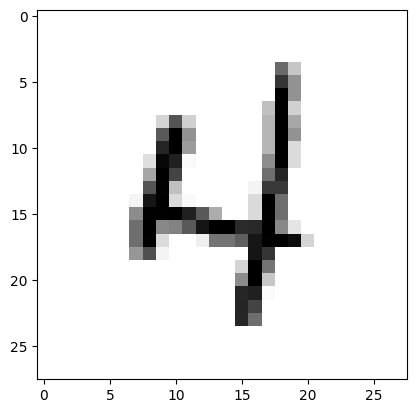

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## More Images

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

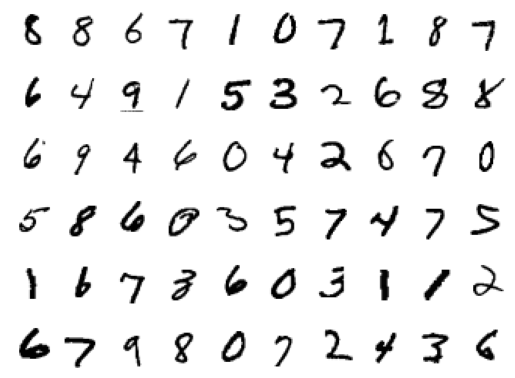

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model

Basic working model with Train & Test Validations

In [8]:
import model1
import utils

from model1 import *
from utils import *

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [9]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,496
              ReLU-4           [-1, 64, 24, 24]               0
            Conv2d-5          [-1, 128, 22, 22]          73,856
              ReLU-6          [-1, 128, 22, 22]               0
         MaxPool2d-7          [-1, 128, 11, 11]               0
            Conv2d-8            [-1, 256, 9, 9]         295,168
              ReLU-9            [-1, 256, 9, 9]               0
           Conv2d-10            [-1, 256, 7, 7]         590,080
             ReLU-11            [-1, 256, 7, 7]               0
           Conv2d-12            [-1, 512, 5, 5]       1,180,160
             ReLU-13            [-1, 512, 5, 5]               0
           Conv2d-14           [-1

# Training and Testing

We have 6.9M params for this model

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

# Train and Test of our model

In [11]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1 )
    train(model, device, train_loader, optimizer, epoch,train_losses, train_acc)
    test(model, device, test_loader,test_losses, test_acc)

EPOCH: 1


Loss=0.10200393199920654 Batch_id=468 Accuracy=77.83: 100%|██████████| 469/469 [00:25<00:00, 18.22it/s]



Test set: Average loss: 0.0933, Accuracy: 9700/10000 (97.00%)

EPOCH: 2


Loss=0.02532772719860077 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:24<00:00, 19.06it/s]



Test set: Average loss: 0.0475, Accuracy: 9864/10000 (98.64%)

EPOCH: 3


Loss=0.036195918917655945 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:23<00:00, 19.72it/s]



Test set: Average loss: 0.0438, Accuracy: 9863/10000 (98.63%)

EPOCH: 4


Loss=0.014871266670525074 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:23<00:00, 19.82it/s]



Test set: Average loss: 0.0416, Accuracy: 9864/10000 (98.64%)

EPOCH: 5


Loss=0.001742290798574686 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:23<00:00, 19.91it/s]



Test set: Average loss: 0.0301, Accuracy: 9905/10000 (99.05%)

EPOCH: 6


Loss=0.02234945259988308 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:24<00:00, 19.33it/s]



Test set: Average loss: 0.0421, Accuracy: 9879/10000 (98.79%)

EPOCH: 7


Loss=0.014925636351108551 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:23<00:00, 19.76it/s]



Test set: Average loss: 0.0497, Accuracy: 9862/10000 (98.62%)

EPOCH: 8


Loss=0.0013712408253923059 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:23<00:00, 19.87it/s]



Test set: Average loss: 0.0298, Accuracy: 9903/10000 (99.03%)

EPOCH: 9


Loss=0.0006008554482832551 Batch_id=468 Accuracy=99.63: 100%|██████████| 469/469 [00:23<00:00, 20.27it/s]



Test set: Average loss: 0.0337, Accuracy: 9909/10000 (99.09%)

EPOCH: 10


Loss=0.007849284447729588 Batch_id=468 Accuracy=99.70: 100%|██████████| 469/469 [00:22<00:00, 20.46it/s]



Test set: Average loss: 0.0388, Accuracy: 9890/10000 (98.90%)

EPOCH: 11


Loss=0.0005812471499666572 Batch_id=468 Accuracy=99.73: 100%|██████████| 469/469 [00:24<00:00, 19.21it/s]



Test set: Average loss: 0.0359, Accuracy: 9901/10000 (99.01%)

EPOCH: 12


Loss=0.0028608303982764482 Batch_id=468 Accuracy=99.79: 100%|██████████| 469/469 [00:23<00:00, 20.34it/s]



Test set: Average loss: 0.0408, Accuracy: 9902/10000 (99.02%)

EPOCH: 13


Loss=0.0018038814887404442 Batch_id=468 Accuracy=99.84: 100%|██████████| 469/469 [00:22<00:00, 20.83it/s]



Test set: Average loss: 0.0395, Accuracy: 9909/10000 (99.09%)

EPOCH: 14


Loss=0.11173742264509201 Batch_id=468 Accuracy=99.81: 100%|██████████| 469/469 [00:22<00:00, 21.16it/s]



Test set: Average loss: 0.0410, Accuracy: 9915/10000 (99.15%)

EPOCH: 15


Loss=0.0007208657916635275 Batch_id=468 Accuracy=99.85: 100%|██████████| 469/469 [00:23<00:00, 19.92it/s]



Test set: Average loss: 0.0413, Accuracy: 9901/10000 (99.01%)



In [13]:
train_losses1 = [t.cpu().item() for t in train_losses]

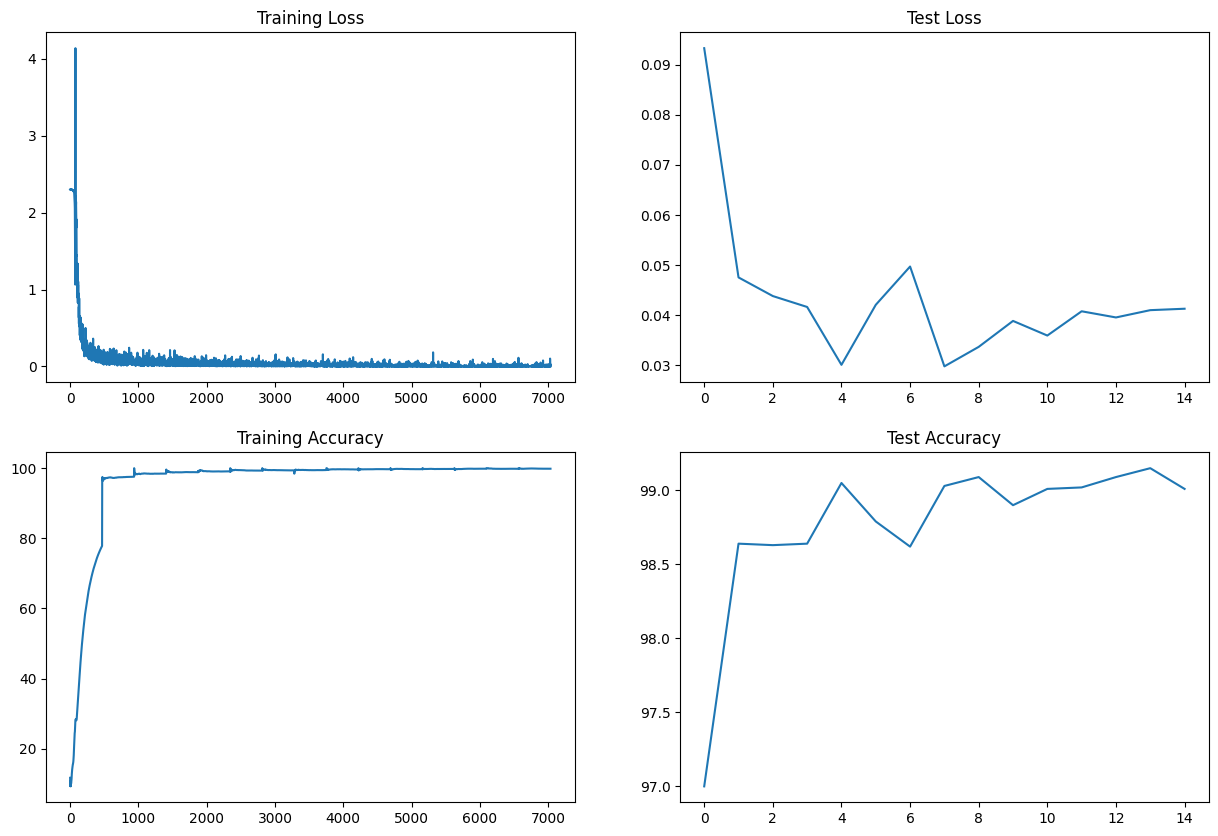

In [14]:
print_graph(train_losses1,train_acc, test_losses,test_acc)